##Introduction
**This Task is an example of Multi regression**

##Import Libraries

In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import cluster
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Download Data

In [2]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')
print("Data shape is :", data.shape)
data.head()

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6043, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6043 (delta 0), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6043/6043), 329.52 MiB | 17.40 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Checking out files: 100% (5805/5805), done.
Data shape is : (3462, 137)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [5]:
data['Unnamed: 0'] = root_dir + data['Unnamed: 0']
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,P1_Facial_Keypoints/data/training/Luis_Fonsi_2...,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,P1_Facial_Keypoints/data/training/Lincoln_Chaf...,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,P1_Facial_Keypoints/data/training/Valerie_Harp...,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,P1_Facial_Keypoints/data/training/Angelo_Reyes...,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,P1_Facial_Keypoints/data/training/Kristen_Brei...,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


##Build Data Loader

In [18]:
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])

  def __len__(self):
    return len(self.df)

  def __getitem__(self, ix):
    img_path = self.df.iloc[ix,0]
    img = cv2.imread(img_path)/255.0
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    
    #Note Here every point is a form of (x, y)
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist() 
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    '''
    We are ensuring that key points are provided as a proportion of 
    the original image's size. This is done so that when we resize 
    the original image, the location of the key points is not changed,
    as the key points are provided as a proportion of the original image.
    Furthermore, by getting key points as a proportion of the original
    image, we have expected output values that are between 0 and 1.
    '''

    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img, kp2

  def preprocess_input(self, img):
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix):
    img_path = self.df.iloc[ix,0]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img, (224,224))
    return img

##Splitting the data

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=101)

train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

##Build the model

In [13]:
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential( nn.Conv2d(512,512,3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten())
  #We have 136 outputs
  model.classifier = nn.Sequential(
                      nn.Linear(2048, 512),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(512, 136),
                      nn.Sigmoid()
                      )
  
  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), criterion, optimizer

##Build training Functions

In [14]:
model, criterion, optimizer = get_model()
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

def validate_batch(img, kps, model, criterion):
  model.eval()
  with torch.no_grad():
    _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

##Train for 50 epochs

In [21]:
train_loss, test_loss = [], []
n_epochs = 50
for epoch in range(n_epochs):
  print(f" epoch {epoch+ 1} : 50")
  epoch_train_loss, epoch_test_loss = 0, 0
  for ix, (img,kps) in enumerate(train_loader):
    loss = train_batch(img, kps, model, optimizer, criterion)
    epoch_train_loss += loss.item()
  epoch_train_loss /= (ix+1)
  for ix,(img,kps) in enumerate(test_loader):
    ps, loss = validate_batch(img, kps, model, criterion)
    epoch_test_loss += loss.item()
  epoch_test_loss /= (ix+1)
  
  train_loss.append(epoch_train_loss)
  test_loss.append(epoch_test_loss)

 epoch 1 : 50
 epoch 2 : 50
 epoch 3 : 50
 epoch 4 : 50
 epoch 5 : 50
 epoch 6 : 50
 epoch 7 : 50
 epoch 8 : 50
 epoch 9 : 50
 epoch 10 : 50
 epoch 11 : 50
 epoch 12 : 50
 epoch 13 : 50
 epoch 14 : 50
 epoch 15 : 50
 epoch 16 : 50
 epoch 17 : 50
 epoch 18 : 50
 epoch 19 : 50
 epoch 20 : 50
 epoch 21 : 50
 epoch 22 : 50
 epoch 23 : 50
 epoch 24 : 50
 epoch 25 : 50
 epoch 26 : 50
 epoch 27 : 50
 epoch 28 : 50
 epoch 29 : 50
 epoch 30 : 50
 epoch 31 : 50
 epoch 32 : 50
 epoch 33 : 50
 epoch 34 : 50
 epoch 35 : 50
 epoch 36 : 50
 epoch 37 : 50
 epoch 38 : 50
 epoch 39 : 50
 epoch 40 : 50
 epoch 41 : 50
 epoch 42 : 50
 epoch 43 : 50
 epoch 44 : 50
 epoch 45 : 50
 epoch 46 : 50
 epoch 47 : 50
 epoch 48 : 50
 epoch 49 : 50
 epoch 50 : 50


##Plot the loss

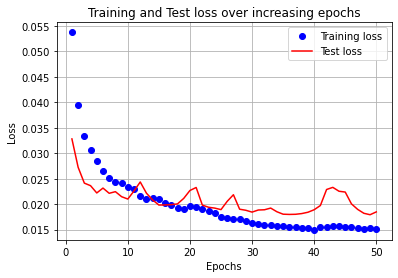

In [22]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

##Test Model on random Image

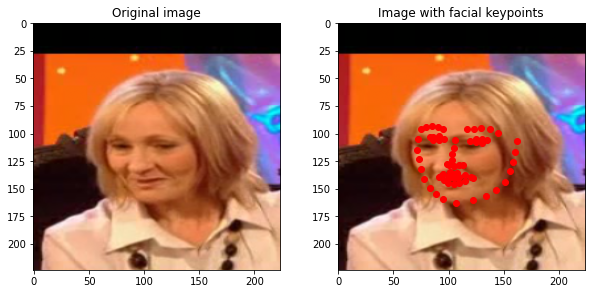

In [23]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()